In [15]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import pyqg
from pyqg import diagnostic_tools as tools

## Defining Basic simulation parameters

In [16]:
year = 24*60*60*360.
base_kwargs = dict(dt=3600., tmax=10*year, tavestart=5*year, twrite=25000)


# High-res model with/without hyperdiffusion

In [18]:
high_res = pyqg.QGModel(nx=256, **base_kwargs)
high_res.run()

high_res_nhpd = pyqg.QGModel(nx=256, hyperdiff = False, **base_kwargs)
high_res_nhpd.run()

KeyboardInterrupt: 

## Defining differnet Cases

In [ ]:
bnn = { "beta": 1.5e-11, #[m^-1 s^-1]
       "delta": 0.25,
       "rek": 5.78e-7, #[s^-1]
       "rd": 15e3, # [m]
}

case1 = { "beta": bnn["beta"]*2/3,
            "delta": bnn["delta"]*2/5,
            "rek": bnn["rek"]*3/25,
            "rd": bnn["rd"],
}

case2 = { "beta": bnn["beta"]*3/10,
            "delta": bnn["delta"]*1/5,
            "rek": bnn["rek"]*3/50,
            "rd": bnn["rd"],
}

case3 = { "beta": bnn["beta"],
            "delta": bnn["delta"],
            "rek": bnn["rek"],
            "rd": bnn["rd"]*4/3,
}

# Setting different cases:
### Low-Res / High-Res
### Different cases: Jet vs. eddy config
### Hyperdiffusion on and off

In [ ]:
year = 24*60*60*360.
base_kwargs = dict(dt=3600., tmax=10*year, tavestart=5*year, twrite=10000)

bnn_lowres = pyqg.QGModel(nx = 64, **base_kwargs, **bnn)
bnn_highres = pyqg.QGModel(nx = 256, **base_kwargs, **bnn)

case1_lowres = pyqg.QGModel(nx = 64, **base_kwargs, **case1)
case1_highres = pyqg.QGModel(nx = 256, **base_kwargs, **case1)

case2_lowres = pyqg.QGModel(nx = 64, **base_kwargs, **case2)
case2_highres = pyqg.QGModel(nx = 256, **base_kwargs, **case2)

case3_lowres = pyqg.QGModel(nx = 64, **base_kwargs, **case3)
case3_highres = pyqg.QGModel(nx = 256, **base_kwargs, **case3)

# For turning off hyperdiffusion, set rhyperdiff = False

bnn_lowres_nhpd = pyqg.QGModel(nx = 64, hyperdiff = False, **base_kwargs, **bnn)
bnn_highres_nhpd = pyqg.QGModel(nx = 256, hyperdiff = False, **base_kwargs, **bnn)

case1_lowres_nhpd = pyqg.QGModel(nx = 64, hyperdiff = False, **base_kwargs, **case1)
case1_highres_nhpd = pyqg.QGModel(nx = 256, hyperdiff = False, **base_kwargs, **case1)

case2_lowres_nhpd = pyqg.QGModel(nx = 64, hyperdiff = False, **base_kwargs, **case2)
case2_highres_nhpd = pyqg.QGModel(nx = 256, hyperdiff = False, **base_kwargs, **case2)

case3_lowres_nhpd = pyqg.QGModel(nx = 64, hyperdiff = False, **base_kwargs, **case3)
case3_highres_nhpd = pyqg.QGModel(nx = 256, hyperdiff = False, **base_kwargs, **case3)

In [ ]:

import xarray as xr
import numpy as np
import pyqg

def drop_vars(ds):
    '''
    Drop complex variables 
    and convert to float32
    '''
    for key,var in ds.variables.items():
        if var.dtype == np.float64:
            ds[key] = var.astype(np.float32)
        elif var.dtype == np.complex128:
            ds = ds.drop_vars(key)
    for key in ['dqdt', 'ufull', 'vfull']:
        if key in ds.keys():
            ds = ds.drop_vars([key])
    if 'p' in ds.keys():
        ds = ds.rename({'p': 'psi'}) # Change for conventional name
    
    if ds['time'].attrs['units'] != 'days':
        ds['time'] = ds.time.values / 86400
        ds['time'].attrs['units'] = 'days'
    
    return ds

def concat_in_time(datasets):
    '''
    Concatenation of snapshots in time:
    - Concatenate everything
    - Store averaged statistics
    - Discard complex vars
    - Reduce precision
    '''
    from time import time
    # Concatenate datasets along the time dimension
    tt = time()
    ds = xr.concat(datasets, dim='time')

    # Spectral statistics are taken from the last 
    # snapshot because it is time-averaged
    for key in datasets[-1].keys():
        if 'k' in datasets[-1][key].dims:
            ds[key] = datasets[-1][key].isel(time=-1)
        
    ds = drop_vars(ds)

    return ds

def run_simulation(pyqg_params, parameterization=None, sampling_freq=100):
    '''
    pyqg_params - only str-type parameters
    parameterization - pyqg parameterization class
    q_init - initial conditiona for PV, numpy array nlev*ny*nx
    '''
    ds = None
    pyqg_params['tmax'] = float(pyqg_params['tmax'])
    if parameterization is None:
        m = pyqg.QGModel(**pyqg_params)
    else:
        params = pyqg_params.copy()
        params['parameterization'] = parameterization
        m = pyqg.QGModel(params, )
    print("Inside run_simulation function: ", sampling_freq)
    for t in m.run_with_snapshots(tsnapint=sampling_freq):
        _ds = drop_vars(m.to_dataset()).copy(deep=True)
        if ds is None:
            ds = _ds
        else:
            ds = concat_in_time([ds, _ds])
            
    ds.attrs['pyqg_params'] = str(pyqg_params)
    return ds

def run_parameterized_model(model, case, base_kwargs, sampling_freq=100):
  parameterization = model # White noise in time sampling
  pyqg_params = {**case , **base_kwargs}
  ds = run_simulation(pyqg_params, parameterization, sampling_freq=sampling_freq)
  return ds


In [ ]:
year = 24*60*60*360.

expected_vars = [
    'q', 
    'u', 
    'v', 
    # 'ufull', 
    # 'vfull', 
    'p',
    # 'dqdt',
    # 'qh', 
    # 'uh', 
    # 'vh', 
    # 'ph', 
    # 'Ubg', 
    'Qy',
    # 'dqhdt',
]

expected_diags = [
    'EKE', 
    'entspec', 
    'APEflux', 
    'APEflux_div', 
    'KEflux', 
    'KEflux_div', 
    'APEgen',
    'APEgenspec',
    'Ensspec',
    'KEspec',
    'EKEdiss',
    'KEspec_modal',
    'PEspec_modal',
    'APEspec',
    'ENSflux',
    'ENSgenspec',
    'paramspec',
    'paramspec_APEflux',
    'paramspec_KEflux',
    'Dissspec',
    'KEfrictionspec',
    'ENSDissspec',
    'ENSfrictionspec',
    'ENSparamspec',
]

expected_attrs = [
    'L',
    'W',
    'dt',
    'filterfac',
    'nk',
    'nl',
    'ntd',
    'nx',
    'ny',
    'nz',
    'rek',
    'taveint',
    'tavestart',
    'tc',
    'tmax',
    'twrite',
]

expected_coords = [
    'time',
    'lev',
    'x',
    'y',
    'l',
    'k',
]


In [ ]:
def test_xarray(all_models):
    '''Run with snapshots and test contents of xarray.dataset'''
    m=all_models
    tsnapint=year/4
    datasets = []
    timevals = []

    for snapshot in m.run_with_snapshots(tsnapstart=m.t, tsnapint=tsnapint):
        ds = m.to_dataset()
        assert type(ds) == xr.Dataset

        datasets.append(ds)
        timevals.append(m.t)

        if snapshot < tsnapint:

            for v in expected_vars:
                assert v in ds

            for a in expected_attrs:
                assert f"pyqg:{a}" in ds.attrs

            for c in expected_coords:
                assert c in ds.coords

        if snapshot > tsnapint:

            for v in list(ds.keys()): 
                assert v in expected_vars + expected_diags

            for v in expected_diags:
                if v in ds:
                    assert 'time' in ds[v].coords

            for a in expected_attrs:
                assert f"pyqg:{a}" in ds.attrs

            for c in expected_coords:
                assert c in ds.coords

    concatenated = xr.concat(datasets, dim='time')

    assert np.allclose(concatenated.coords['time'], timevals)

In [ ]:
test_xarray(pyqg.QGModel(nx = 64, **base_kwargs, **bnn))

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug
INFO:  Logger initialized


AssertionError: 

In [ ]:
base_kwargs['tmax'] = 0.1*year
lores = run_parameterized_model(model=None, case={'nx':64, **bnn}, base_kwargs=base_kwargs, sampling_freq=20)



RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug
INFO:  Logger initialized


Inside run_simulation function:  20


In [ ]:
def ave_lev(arr: xr.DataArray, delta):
    '''
    Average over depth xarray
    delta = H1/H2
    H = H1+H2
    Weights are:
    Hi[0] = H1/H = H1/(H1+H2)=H1/H2/(H1/H2+1)=delta/(1+delta)
    Hi[1] = H2/H = H2/(H1+H2)=1/(1+delta)
    '''
    if 'lev' in arr.dims:
        Hi = xr.DataArray([delta/(1+delta), 1/(1+delta)], dims=['lev'])
        out  = (arr*Hi).sum(dim='lev')
        out.attrs = arr.attrs
        return out
    else:
        return arr

def KE(ds):
  if 'run' in ds.dims:
    dims = ['x', 'y', 'run']
  else:
    dims = ['x', 'y']
  return (ave_lev(0.5 * (ds.u**2 + ds.v**2), delta=0.25)).mean(dims)
     

In [ ]:
lores

<xarray.Dataset>
Dimensions:  (time: 864, lev: 2, y: 64, x: 64, lev_mid: 1, l: 64, k: 33)
Coordinates:
  * time     (time) float32 0.04167 0.08333 0.125 0.1667 ... 35.92 35.96 36.0
  * lev      (lev) int64 1 2
  * lev_mid  (lev_mid) float32 1.5
  * x        (x) float32 7.812e+03 2.344e+04 3.906e+04 ... 9.766e+05 9.922e+05
  * y        (y) float32 7.812e+03 2.344e+04 3.906e+04 ... 9.766e+05 9.922e+05
  * l        (l) float32 0.0 6.283e-06 1.257e-05 ... -1.257e-05 -6.283e-06
  * k        (k) float32 0.0 6.283e-06 1.257e-05 ... 0.0001948 0.0002011
Data variables:
    q        (time, lev, y, x) float32 7.228e-07 8.432e-08 ... 4.908e-09
    u        (time, lev, y, x) float32 1.046e-05 8.555e-06 ... 8.11e-06
    v        (time, lev, y, x) float32 0.00603 0.003515 ... 5.365e-05 0.000134
    Ubg      (time, lev) float32 0.025 0.0 0.025 0.0 ... 0.025 0.0 0.025 0.0
    Qy       (time, lev) float32 1.039e-10 -7.222e-12 ... 1.039e-10 -7.222e-12
    psi      (time, lev, y, x) float32 165.4 249.7 265.3 ... 63.05 62.73 64.63
Attributes: (12/24)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         3600.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:tmax:       3110400.0
    pyqg:twrite:     10000
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    pyqg_params:     {'nx': 64, 'beta': 1.5e-11, 'delta': 0.25, 'rek': 5.78e-...

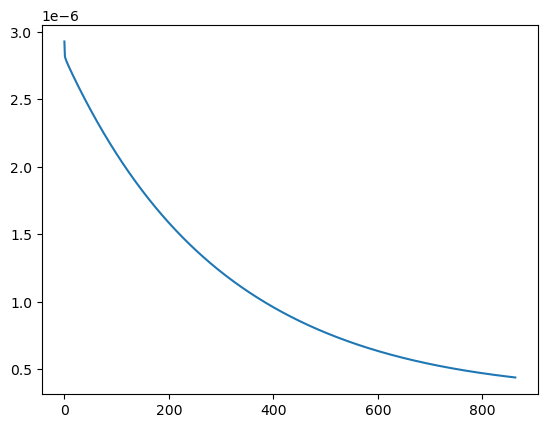

In [ ]:
import matplotlib.pyplot as plt
plt.plot(KE(lores))

lore

#### Choose which model to run:

In [ ]:
bnn_lowres.run()


INFO: Step: 10000, Time: 3.60e+07, KE: 9.00e-06, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 3.00e-04, CFL: 0.038
INFO: Step: 30000, Time: 1.08e+08, KE: 4.52e-04, CFL: 0.043
INFO: Step: 40000, Time: 1.44e+08, KE: 5.10e-04, CFL: 0.042
INFO: Step: 50000, Time: 1.80e+08, KE: 4.65e-04, CFL: 0.045
INFO: Step: 60000, Time: 2.16e+08, KE: 4.51e-04, CFL: 0.050
INFO: Step: 70000, Time: 2.52e+08, KE: 5.02e-04, CFL: 0.044
INFO: Step: 80000, Time: 2.88e+08, KE: 4.98e-04, CFL: 0.047


In [ ]:
bnn_lowres.to_dataset().isel(time=-1)

<xarray.Dataset>
Dimensions:            (lev: 2, y: 64, x: 64, l: 64, k: 33, lev_mid: 1)
Coordinates:
    time               float64 3.11e+08
  * lev                (lev) int64 1 2
  * lev_mid            (lev_mid) float64 1.5
  * x                  (x) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y                  (y) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * l                  (l) float64 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * k                  (k) float64 0.0 6.283e-06 ... 0.0001948 0.0002011
Data variables: (12/33)
    q                  (lev, y, x) float64 5.415e-06 3.038e-06 ... 1.018e-07
    u                  (lev, y, x) float64 -0.03334 -0.01695 ... -0.003222
    v                  (lev, y, x) float64 -0.01547 0.02445 ... -0.00173
    ufull              (lev, y, x) float64 -0.00834 0.008046 ... -0.003222
    vfull              (lev, y, x) float64 -0.01547 0.02445 ... -0.00173
    qh                 (lev, l, k) complex128 (0.0019670843644227546+0j) ... ...
    ...                 ...
    ENSgenspec         (l, k) float64 0.0 -3.053e-23 ... -8.339e-52 1.342e-61
    ENSfrictionspec    (l, k) float64 0.0 -3.494e-24 ... -7.199e-51 -2.601e-60
    APEgenspec         (l, k) float64 0.0 -6.87e-15 ... -1.876e-43 3.02e-53
    APEflux            (l, k) float64 -0.0 1.369e-14 ... 5.538e-29 1.465e-33
    KEflux             (l, k) float64 0.0 3.268e-15 ... 2.334e-27 5.101e-32
    APEgen             float64 6.731e-11
Attributes: (12/23)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         3600.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:tc:         86400
    pyqg:tmax:       311040000.0
    pyqg:twrite:     10000
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html

In [ ]:
print("BNN High-res")
bnn_lowres.run()
print("BNN Low-res")
bnn_highres.run()

# print("Case1 Low-res")
# case1_lowres.run()
# print("Case1 High-res")
# case1_highres.run()

print("Case2 Low-res")
case2_lowres.run()
print("Case2 High-res")
case2_highres.run()

print("Case3 Low-res")
case3_lowres.run()
print("Case3 High-res")
case3_highres.run()

# Hyperdiffusion off
print("BNN High-res")
bnn_lowres_nhpd.run()
print("BNN Low-res")
bnn_highres_nhpd.run()

print("Case1 Low-res")
case1_lowres_nhpd.run()
print("Case1 High-res")
case1_highres_nhpd.run()

print("Case2 Low-res")
case2_lowres_nhpd.run()
print("Case2 High-res")
case2_highres_nhpd.run()

print("Case3 Low-res")
case3_lowres_nhpd.run()
print("Case3 High-res")
case3_highres_nhpd.run()

BNN High-res


INFO: Step: 10000, Time: 3.60e+07, KE: 1.37e-05, CFL: 0.007
INFO: Step: 20000, Time: 7.20e+07, KE: 3.55e-04, CFL: 0.041
INFO: Step: 30000, Time: 1.08e+08, KE: 4.32e-04, CFL: 0.043
INFO: Step: 40000, Time: 1.44e+08, KE: 5.04e-04, CFL: 0.046
INFO: Step: 50000, Time: 1.80e+08, KE: 5.03e-04, CFL: 0.051
INFO: Step: 60000, Time: 2.16e+08, KE: 4.97e-04, CFL: 0.051
INFO: Step: 70000, Time: 2.52e+08, KE: 4.75e-04, CFL: 0.049
INFO: Step: 80000, Time: 2.88e+08, KE: 4.89e-04, CFL: 0.046


BNN Low-res


INFO: Step: 10000, Time: 3.60e+07, KE: 1.60e-06, CFL: 0.024
INFO: Step: 20000, Time: 7.20e+07, KE: 1.64e-04, CFL: 0.087
INFO: Step: 30000, Time: 1.08e+08, KE: 5.81e-04, CFL: 0.180
INFO: Step: 40000, Time: 1.44e+08, KE: 6.37e-04, CFL: 0.294
INFO: Step: 50000, Time: 1.80e+08, KE: 6.01e-04, CFL: 0.234
INFO: Step: 60000, Time: 2.16e+08, KE: 6.07e-04, CFL: 0.212
INFO: Step: 70000, Time: 2.52e+08, KE: 5.87e-04, CFL: 0.214
INFO: Step: 80000, Time: 2.88e+08, KE: 5.89e-04, CFL: 0.217


Case2 Low-res


INFO: Step: 10000, Time: 3.60e+07, KE: 1.33e-07, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 5.18e-07, CFL: 0.006
INFO: Step: 30000, Time: 1.08e+08, KE: 4.11e-06, CFL: 0.006
INFO: Step: 40000, Time: 1.44e+08, KE: 5.46e-05, CFL: 0.022
INFO: Step: 50000, Time: 1.80e+08, KE: 1.86e-04, CFL: 0.049
INFO: Step: 60000, Time: 2.16e+08, KE: 1.42e-04, CFL: 0.045
INFO: Step: 70000, Time: 2.52e+08, KE: 1.07e-04, CFL: 0.034
INFO: Step: 80000, Time: 2.88e+08, KE: 1.36e-04, CFL: 0.042


Case2 High-res


INFO: Step: 10000, Time: 3.60e+07, KE: 4.16e-08, CFL: 0.023
INFO: Step: 20000, Time: 7.20e+07, KE: 2.98e-07, CFL: 0.024
INFO: Step: 30000, Time: 1.08e+08, KE: 5.79e-06, CFL: 0.024
INFO: Step: 40000, Time: 1.44e+08, KE: 1.35e-04, CFL: 0.095
INFO: Step: 50000, Time: 1.80e+08, KE: 5.98e-04, CFL: 0.290
INFO: Step: 60000, Time: 2.16e+08, KE: 3.84e-04, CFL: 0.263
INFO: Step: 70000, Time: 2.52e+08, KE: 3.06e-04, CFL: 0.255
INFO: Step: 80000, Time: 2.88e+08, KE: 2.23e-04, CFL: 0.222


Case3 Low-res


INFO: Step: 10000, Time: 3.60e+07, KE: 1.38e-06, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 9.06e-06, CFL: 0.006
INFO: Step: 30000, Time: 1.08e+08, KE: 7.94e-05, CFL: 0.017
INFO: Step: 40000, Time: 1.44e+08, KE: 1.41e-04, CFL: 0.032
INFO: Step: 50000, Time: 1.80e+08, KE: 1.80e-04, CFL: 0.029
INFO: Step: 60000, Time: 2.16e+08, KE: 2.31e-04, CFL: 0.036
INFO: Step: 70000, Time: 2.52e+08, KE: 2.82e-04, CFL: 0.043
INFO: Step: 80000, Time: 2.88e+08, KE: 2.69e-04, CFL: 0.037


Case3 High-res


INFO: Step: 10000, Time: 3.60e+07, KE: 5.18e-07, CFL: 0.024
INFO: Step: 20000, Time: 7.20e+07, KE: 3.47e-06, CFL: 0.024
INFO: Step: 30000, Time: 1.08e+08, KE: 3.54e-05, CFL: 0.034
INFO: Step: 40000, Time: 1.44e+08, KE: 2.45e-04, CFL: 0.151
INFO: Step: 50000, Time: 1.80e+08, KE: 3.12e-04, CFL: 0.163
INFO: Step: 60000, Time: 2.16e+08, KE: 3.33e-04, CFL: 0.160
INFO: Step: 70000, Time: 2.52e+08, KE: 3.23e-04, CFL: 0.164
INFO: Step: 80000, Time: 2.88e+08, KE: 3.16e-04, CFL: 0.161


BNN High-res


INFO: Step: 10000, Time: 3.60e+07, KE: nan, CFL:  nan
ERROR: CFL condition violated


AssertionError: None

#### Creating dataset out of them:

In [ ]:
# bnn_lowres_ds = bnn_lowres.to_dataset().isel(time=-1)
# bnn_highres_ds = bnn_highres.to_dataset().isel(time=-1)

# case1_lowres_ds = case1_lowres.to_dataset().isel(time=-1)
# case1_highres_ds = case1_highres.to_dataset().isel(time=-1)

case2_lowres_ds = case2_lowres.to_dataset().isel(time=-1)
case2_highres_ds = case2_highres.to_dataset().isel(time=-1)

# case3_lowres_ds = case3_lowres.to_dataset().isel(time=-1)
# case3_highres_ds = case3_highres.to_dataset().isel(time=-1)

# Hyper Diffusion Off
# bnn_lowres_nhpd_ds = bnn_lowres_nhpd.to_dataset().isel(time=-1)
# bnn_highres_nhpd_ds = bnn_highres_nhpd.to_dataset().isel(time=-1)

# case1_lowres_nhpd_ds = case1_lowres_nhpd.to_dataset().isel(time=-1)
# case1_highres_nhpd_ds = case1_highres_nhpd.to_dataset().isel(time=-1)

# case2_lowres_nhpd_ds = case2_lowres_nhpd.to_dataset().isel(time=-1)
# case2_highres_nhpd_ds = case2_highres_nhpd.to_dataset().isel(time=-1)

# case3_lowres_nhpd_ds = case3_lowres_nhpd.to_dataset().isel(time=-1)
# case3_highres_nhpd_ds = case3_highres_nhpd.to_dataset().isel(time=-1)

# Testing my CNNparametrization

In [ ]:
import torch
import torch.nn as nn
from pyqg import Parameterization

class CNNparametrization(Parameterization):
    def __init__(self, model_type, model_path):
        super().__init__()
        self.model = self.init_model(model_type, model_path)

    def __call__(self, m):
        # Here you will need to transform your model `m` into the appropriate input tensor for the CNN
        # As I don't know the exact structure of your model and the expected input for the CNN, 
        # I'm using a placeholder function `prepare_input(m)`. You will need to implement this function.
        input_tensor = self.prepare_input(m) 
        # Then you can use the evaluate_model function to get the output of the CNN
        output = self.evaluate_model(self.model, input_tensor)
        return output
    
    @staticmethod
    def prepare_input(m):
        # get the model variables 'u' and 'v'
        u = m.u
        v = m.v
        # Ensure that 'u' and 'v' are numpy arrays
        if not isinstance(u, np.ndarray):
            u = np.array(u)
        if not isinstance(v, np.ndarray):
            v = np.array(v)
        # concatenate 'u' and 'v' across the first axis
        combined = np.concatenate((u, v), axis=0)
        # Convert the combined array to a torch tensor
        input_tensor = torch.from_numpy(combined)
        # Ensure the tensor is of the right type
        input_tensor = input_tensor.float()
        return input_tensor
    
    @staticmethod
    def evaluate_model(model, input_tensor):
        # Set device to GPU if available, otherwise use CPU
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Move the input tensor to the specified device
        input_tensor = input_tensor.to(device=device)
        
        # # Normalize the input tensor
        # training_mean_std = {
        #     "input_mean_train": torch.tensor([1.5142133559390217e-14, -2.3737904545663435e-13, 1.2836868070256746e-12, -3.642309706879815e-13]).to(device),
        #     "input_std_train": torch.tensor([0.04329422116279602, 0.00804091151803732, 0.043515775352716446, 0.007541385013610125]).to(device),
        #     "output_mean_train": torch.tensor([-4.4214735503544034e-23, 2.5631344976210459e-26]).to(device),
        #     "output_std_train": torch.tensor([2.8334667511592526e-12, 9.65022603927751e-15]).to(device)
        # }
        training_mean_std = {
                    "input_mean_train": torch.tensor([-1.7344221761930734e-12, -1.011645845219733e-12, -4.31288164903787e-12, -2.4823882099206385e-13]).to(device),
                    "input_std_train": torch.tensor([0.04459216445684433, 0.008588222786784172, 0.0439789704978466, 0.00786646455526352]).to(device),
                    "output_mean_train": torch.tensor([-1.9396071753189125e-23, -5.184367738095004e-25]).to(device),
                    "output_std_train": torch.tensor([2.8226234283917906e-12, 1.0289057441063756e-14]).to(device)
                }
        
        input_tensor = (input_tensor - training_mean_std["input_mean_train"][:, None, None]) / training_mean_std["input_std_train"][:, None, None]
        
        # Pass the input tensor through the model
        output, _ = model(input_tensor)
        
        # Denormalize the output tensor
        output = output * training_mean_std["output_std_train"][:, None, None] + training_mean_std["output_mean_train"][:, None, None]
        
        # Move the output tensor back to the CPU and numpy
        output = output.cpu().detach().numpy()
        
        # Ensure 'output' is of type float64
        output = output.astype(np.float64)

        return output

    
    @staticmethod
    def init_model(model_type, model_path):
        # Define the ConvNeuralNet classes for each model type
        if model_type == 'deep':
            class ConvNeuralNet(nn.Module):
                
                # Determine what layers and their order in CNN object
                def __init__(self, num_classes):

                        super(ConvNeuralNet, self).__init__()

                        # Input Layer
                        self.conv_layer1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=5, padding="same")
                        
                        # Hidden layers
                        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        self.conv_layer5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        self.conv_layer6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        self.conv_layer7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        # self.conv_layer8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        # self.conv_layer9 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        # self.conv_layer10 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding="same")
                        
                        # Output layer
                        self.conv_layer11 = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=5, padding="same")
                        
                        # Activation function
                        self.relu1 = nn.ReLU()
                        
                def forward(self, x):

                        out1_before = self.conv_layer1(x) # Layer1 (Input Layer)
                        out1_after = self.relu1(out1_before) # Layer1 (Input Layer)    
                        
                        ## Hidden Layers
                        out2_before = self.conv_layer2(out1_after) #Layer2
                        out2_after = self.relu1(out2_before) #Layer2
                    
                        out3_before = self.conv_layer3(out2_after) #Layer3
                        out3_after = self.relu1(out3_before) #Layer3

                        out4_before = self.conv_layer4(out3_after) #Layer4
                        out4_after = self.relu1(out4_before) #Layer4

                        out5_before = self.conv_layer5(out4_after) #Layer5
                        out5_after = self.relu1(out5_before) #Layer5

                        out6_before = self.conv_layer6(out5_after) #Layer6
                        out6_after = self.relu1(out6_before) #Layer6

                        out7_before = self.conv_layer7(out6_after) #Layer7
                        out7_after = self.relu1(out7_before) #Layer7

                        # out8 = self.relu1(self.conv_layer8(out7)) #Layer8

                        # out9 = self.relu1(self.conv_layer9(out8)) #Layer9

                        # out10 = self.relu1(self.conv_layer10(out9)) #Layer10
                        
                        ####  !!! Do not forget to change teh output layer when changing the number of hidden layers !!! ####

                        output = self.conv_layer11(out7_after) #Layer11 (Output Layer) 
                        mid_ouptut = {'out1_before': out1_before, 'out1_after': out1_after, 'out2_before': out2_before, 'out2_after': out2_after, 'out3_before': out3_before, 'out3_after': out3_after, 'out4_before': out4_before, 'out4_after': out4_after, 'out5_before': out5_before, 'out5_after': out5_after, 'out6_before': out6_before, 'out6_after': out6_after, 'out7_before': out7_before, 'out7_after': out7_after}
                        return output, mid_ouptut
        else:
            print('Invalid model type. Please choose from "deep" or "shallow"')

        # Set device to GPU if available, otherwise use CPU
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Create model instance and move it to the specified device
        model = ConvNeuralNet(1).to(device=device)

        # Load the checkpoint
        checkpoint = torch.load(model_path, map_location=device)

        # Extract the model_state_dict from the checkpoint
        model_state_dict = checkpoint['model_state_dict']

        # Load the state dictionary into the model
        model.load_state_dict(model_state_dict)

        # Move the model to the specified device
        model.to(device)

        # Set the model to evaluation mode
        model.eval()

        return model

    @property
    def parameterization_type(self):
        return "q_parameterization"
    

class CNNparametrizationModified(CNNparametrization):
    def __init__(self, model_type, model_path):
        super().__init__(model_type, model_path)

    @staticmethod
    def evaluate_model(model, input_tensor):
        # Set device to GPU if available, otherwise use CPU
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Move the input tensor to the specified device
        input_tensor = input_tensor.to(device=device)
        
        # Normalize the input tensor with modified mean and std
        class CNNparametrizationModified(CNNparametrization):
            def __init__(self, model_type, model_path):
                super().__init__(model_type, model_path)

            @staticmethod
            def evaluate_model(model, input_tensor):
                # Set device to GPU if available, otherwise use CPU
                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                # Move the input tensor to the specified device
                input_tensor = input_tensor.to(device=device)
                
                # Normalize the input tensor with new mean and std
                training_mean_std = {
                    "input_mean_train": torch.tensor([-1.7344221761930734e-12, -1.011645845219733e-12, -4.31288164903787e-12, -2.4823882099206385e-13]).to(device),
                    "input_std_train": torch.tensor([0.04459216445684433, 0.008588222786784172, 0.0439789704978466, 0.00786646455526352]).to(device),
                    "output_mean_train": torch.tensor([-1.9396071753189125e-23, -5.184367738095004e-25]).to(device),
                    "output_std_train": torch.tensor([2.8226234283917906e-12, 1.0289057441063756e-14]).to(device)
                }
                
                input_tensor = (input_tensor - training_mean_std["input_mean_train"][:, None, None]) / training_mean_std["input_std_train"][:, None, None]
                
                # Pass the input tensor through the model
                output, _ = model(input_tensor)
                
                # Denormalize the output tensor
                output = output * training_mean_std["output_std_train"][:, None, None] + training_mean_std["output_mean_train"][:, None, None]
                
                # Move the output tensor back to the CPU and numpy
                output = output.cpu().detach().numpy()
                
                # Ensure 'output' is of type float64
                output = output.astype(np.float64)

                return output


## Initialize the CNN parameterization class

In [ ]:
model_type = "deep"
model_path = "results/BNN/BestModelBasedOnTestLoss.pt"

# First, create an instance of your CNNparametrization class
cnn_parametrization = CNNparametrization(model_type, model_path)

TLNN_param = CNNparametrization("deep", "results/Case2/BestModelBasedOnTestLoss.pt")


In [ ]:
def run_parameterized_model(parameterization, case, base_kwargs):
    model = pyqg.QGModel(nx=64, parameterization=parameterization, **case , **base_kwargs)
    model.run()
    return model

In [ ]:
smagorinsky_case2 = run_parameterized_model(
    pyqg.parameterizations.Smagorinsky(constant=0.08), case2, base_kwargs)

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug
INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 1.46e-07, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 9.86e-07, CFL: 0.006
INFO: Step: 30000, Time: 1.08e+08, KE: 1.67e-05, CFL: 0.009
INFO: Step: 40000, Time: 1.44e+08, KE: 3.76e-04, CFL: 0.045
INFO: Step: 50000, Time: 1.80e+08, KE: 2.66e-04, CFL: 0.050
INFO: Step: 60000, Time: 2.16e+08, KE: 1.88e-04, CFL: 0.052
INFO: Step: 70000, Time: 2.52e+08, KE: 1.84e-04, CFL: 0.050
INFO: Step: 80000, Time: 2.88e+08, KE: 1.96e-04, CFL: 0.042


In [ ]:
year = 24*60*60*360.
# case2_model = pyqg.QGModel(tmax=10*year, twrite=10000, tavestart=5*year, **case2)
case2_model_param = pyqg.QGModel(tmax=10*year, twrite=10000, tavestart=5*year, **case2, parameterization=cnn_parametrization)
# case2_model.run()
case2_model_param.run()

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug
INFO:  Logger initialized
INFO: Step: 10000, Time: 7.20e+07, KE: 5.78e-06, CFL: 0.032
INFO: Step: 20000, Time: 1.44e+08, KE: 1.03e-04, CFL: 0.070
INFO: Step: 30000, Time: 2.16e+08, KE: 1.32e-04, CFL: 0.072
INFO: Step: 40000, Time: 2.88e+08, KE: 1.79e-04, CFL: 0.088


In [ ]:
backscatter_case2 = run_parameterized_model(
    pyqg.parameterizations.BackscatterBiharmonic(smag_constant=0.08, back_constant=1.1), case2, base_kwargs)

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug
INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 1.46e-07, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 1.19e-06, CFL: 0.006
INFO: Step: 30000, Time: 1.08e+08, KE: 2.28e-05, CFL: 0.010
INFO: Step: 40000, Time: 1.44e+08, KE: 5.13e-04, CFL: 0.058
INFO: Step: 50000, Time: 1.80e+08, KE: 3.89e-04, CFL: 0.068
INFO: Step: 60000, Time: 2.16e+08, KE: 2.40e-04, CFL: 0.054
INFO: Step: 70000, Time: 2.52e+08, KE: 1.43e-04, CFL: 0.040
INFO: Step: 80000, Time: 2.88e+08, KE: 1.56e-04, CFL: 0.045


In [ ]:
cnn_case2 = run_parameterized_model(
    parameterization=cnn_parametrization, case=case2, base_kwargs=base_kwargs)

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug
INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 2.05e-06, CFL: 0.012
INFO: Step: 20000, Time: 7.20e+07, KE: 7.29e-06, CFL: 0.018
INFO: Step: 30000, Time: 1.08e+08, KE: 3.33e-05, CFL: 0.020
INFO: Step: 40000, Time: 1.44e+08, KE: 8.12e-05, CFL: 0.034
INFO: Step: 50000, Time: 1.80e+08, KE: 1.15e-04, CFL: 0.043
INFO: Step: 60000, Time: 2.16e+08, KE: 1.48e-04, CFL: 0.046
INFO: Step: 70000, Time: 2.52e+08, KE: 1.51e-04, CFL: 0.043
INFO: Step: 80000, Time: 2.88e+08, KE: 1.30e-04, CFL: 0.040


In [ ]:
TLNN_case2 = run_parameterized_model(
    parameterization=TLNN_param, case=case2, base_kwargs=base_kwargs)

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/media/volume/sdc/qg/pyqg/pyqg/pyqg/model.py", line 217, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug
INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 1.66e-06, CFL: 0.012
INFO: Step: 20000, Time: 7.20e+07, KE: 6.56e-06, CFL: 0.018
INFO: Step: 30000, Time: 1.08e+08, KE: 2.17e-05, CFL: 0.020
INFO: Step: 40000, Time: 1.44e+08, KE: 4.42e-05, CFL: 0.030
INFO: Step: 50000, Time: 1.80e+08, KE: 6.48e-05, CFL: 0.032
INFO: Step: 60000, Time: 2.16e+08, KE: 9.30e-05, CFL: 0.038
INFO: Step: 70000, Time: 2.52e+08, KE: 1.16e-04, CFL: 0.039
INFO: Step: 80000, Time: 2.88e+08, KE: 1.65e-04, CFL: 0.041


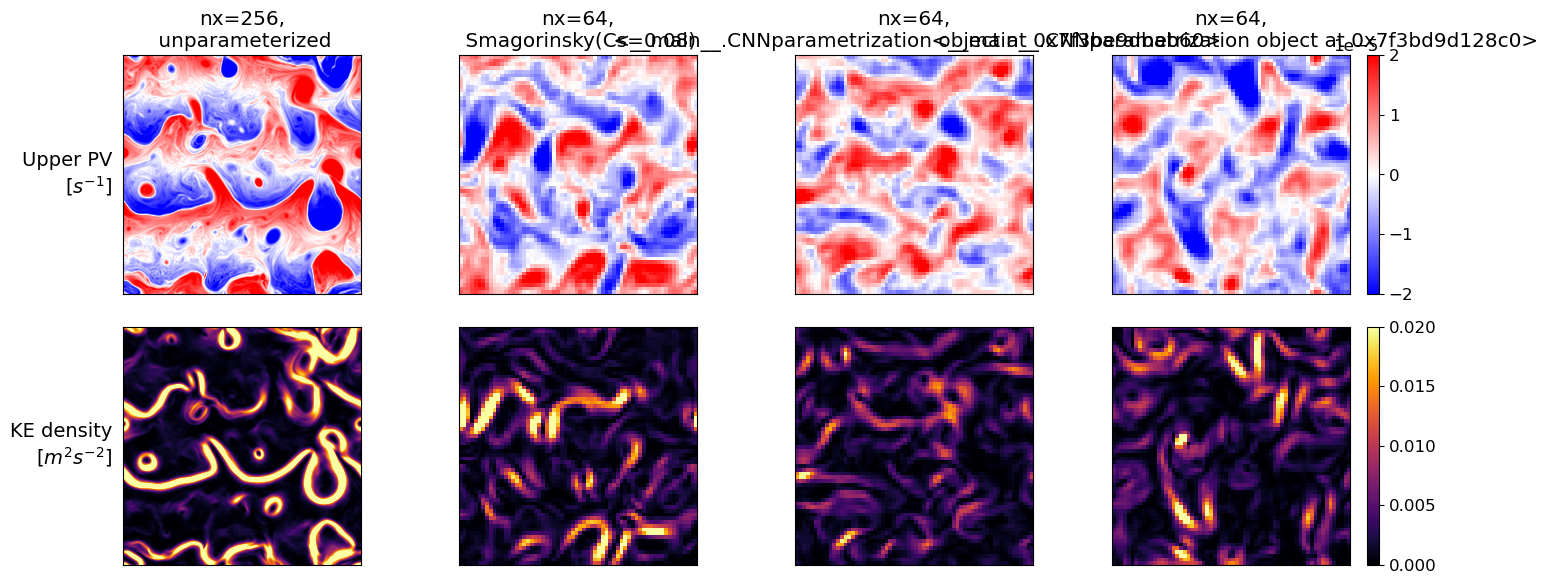

In [ ]:
def label_for(sim):
    return f"nx={sim.nx}, {sim.parameterization or 'unparameterized'}"

plt.figure(figsize=(15,6))
plt.rcParams.update({'font.size': 12})
vlim = 2e-5
for i, sim in enumerate([case2_highres, smagorinsky_case2, cnn_case2, TLNN_case2]):
    plt.subplot(2, 4, i+1, title=label_for(sim).replace(',',",\n").replace('Biharmonic',''))
    plt.imshow(sim.q[0], vmin=-vlim, vmax=vlim, cmap='bwr')
    plt.xticks([]); plt.yticks([])
    if i == 0: plt.ylabel("Upper PV\n[$s^{-1}$]", rotation=0, va='center', ha='right', fontsize=14)
    if i == 3: plt.colorbar()

vlim = 2e-2
for i, sim in enumerate([case2_highres, smagorinsky_case2, cnn_case2, TLNN_case2]):
    plt.subplot(2, 4, i+5)
    plt.imshow((sim.u**2 + sim.v**2).sum(0), vmin=0, vmax=vlim, cmap='inferno')
    plt.xticks([]); plt.yticks([])
    if i == 0: plt.ylabel("KE density\n[$m^2 s^{-2}$]", rotation=0, va='center', ha='right', fontsize=14)
    if i == 3: plt.colorbar()

plt.tight_layout()

In [ ]:
import pandas as pd

sims = [case2_highres, smagorinsky_case2, cnn_case2, TLNN_case2]

pd.DataFrame.from_dict([
    dict(Simulation=label_for(sim),
        **pyqg.diagnostic_tools.diagnostic_similarities(sim, case2_highres, case2_lowres))
    for sim in sims])

,Simulation,Ensspec1,Ensspec2,KEspec1,KEspec2,EKEdiss,KEfrictionspec,EKE1,EKE2,Dissspec,ENSDissspec,entspec,ENSflux,ENSgenspec,ENSfrictionspec,APEgenspec,APEflux,KEflux,APEgen
0,"nx=256, unparameterized",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,"nx=64, Smagorinsky(Cs=0.08)",0.250666,0.071745,0.180863,0.398106,0.387011,0.398106,0.212516,0.387011,-0.077468,-0.077863,0.186536,-0.125946,0.046785,0.329629,0.046785,0.139899,0.129462,0.530676
2,"nx=64, <__main__.CNNparametrization object at ...",-0.102710,-0.386666,-0.101430,0.021332,-0.001613,0.021332,-0.096393,-0.001613,0.647349,0.649516,-0.086978,-0.066175,-0.073097,-0.112397,-0.073097,-0.160929,-0.077047,-0.251348
3,"nx=64, <__main__.CNNparametrization object at ...",-0.204872,-0.512067,-0.206801,-0.075758,-0.088121,-0.075758,-0.210831,-0.088121,0.836820,0.837837,-0.166064,-0.128582,-0.108562,-0.252164,-0.108562,-0.226943,-0.158161,0.104427


In [ ]:
# Compare differne
case2_highres_ds = case2_highres.to_dataset().isel(time=-1)
case2_lowres_ds = case2_lowres.to_dataset().isel(time=-1)
cnn_parametrization_ds = cnn_case2.to_dataset().isel(time=-1)
backscatter_case2_ds = backscatter_case2.to_dataset().isel(time=-1)
smagorinsky_case2_ds = smagorinsky_case2.to_dataset().isel(time=-1)
TLNN_case2_ds = TLNN_case2.to_dataset().isel(time=-1)


In [ ]:
def get_spectra(model, model_ds, level):
    k, kespec = tools.calc_ispec(model, model_ds.KEspec.isel(lev=level).data)
    return k, kespec

kr_highres, kespec_upper_case2_highres = get_spectra(case2_highres, case2_highres_ds, 0)
_, kespec_lower_case2_highres = get_spectra(case2_highres, case2_highres_ds, 1)

kr_lowres, kespec_upper_case2_lowres = get_spectra(case2_lowres, case2_lowres_ds, 0)
_, kespec_lower_case2_lowres = get_spectra(case2_lowres, case2_lowres_ds, 1)

_, kespec_upper_case2_cnn = get_spectra(cnn_case2, cnn_parametrization_ds, 0)
_, kespec_lower_case2_cnn = get_spectra(cnn_case2, cnn_parametrization_ds, 1)

_,kespec_upper_case2_TLNN = get_spectra(TLNN_case2, TLNN_case2_ds, 0)
_,kespec_lower_case2_TLNN = get_spectra(TLNN_case2, TLNN_case2_ds, 1)

_, kespec_upper_case2_backscatter = get_spectra(backscatter_case2, backscatter_case2_ds, 0)
_, kespec_lower_case2_backscatter = get_spectra(backscatter_case2, backscatter_case2_ds, 1)

_, kespec_upper_case2_smagorinsky = get_spectra(smagorinsky_case2, smagorinsky_case2_ds, 0)
_, kespec_lower_case2_smagorinsky = get_spectra(smagorinsky_case2, smagorinsky_case2_ds, 1)


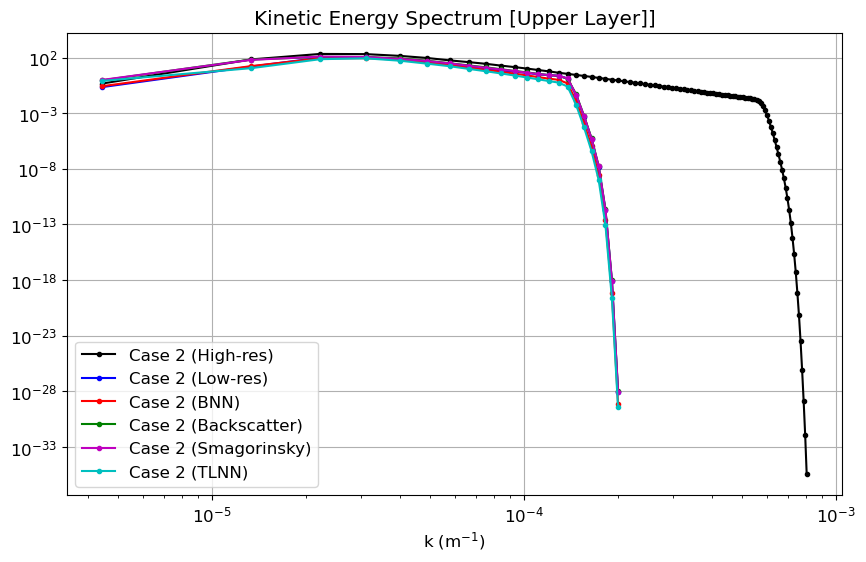

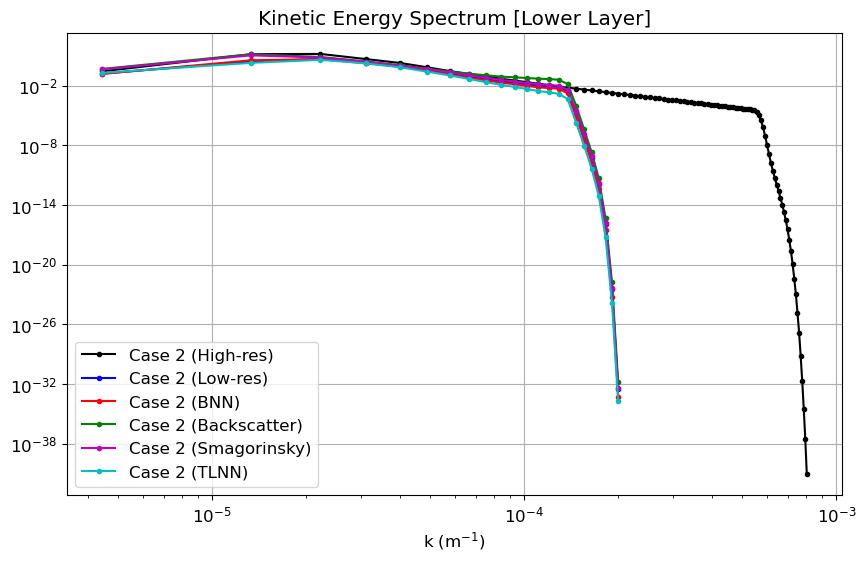

In [ ]:
# Creating subplots
plt.figure(figsize=(10,6))
plt.loglog(kr_highres, kespec_upper_case2_highres, 'k.-', label='Case 2 (High-res)')
plt.loglog(kr_lowres, kespec_upper_case2_lowres, 'b.-', label='Case 2 (Low-res)')
plt.loglog(kr_lowres, kespec_upper_case2_cnn, 'r.-', label='Case 2 (BNN)')
plt.loglog(kr_lowres, kespec_upper_case2_backscatter, 'g.-', label='Case 2 (Backscatter)')
plt.loglog(kr_lowres, kespec_upper_case2_smagorinsky, 'm.-', label='Case 2 (Smagorinsky)')
plt.loglog(kr_lowres, kespec_upper_case2_TLNN, 'c.-', label='Case 2 (TLNN)')
plt.legend(loc='lower left')
plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
plt.title('Kinetic Energy Spectrum [Upper Layer]]')

plt.figure(figsize=(10,6))
plt.loglog(kr_highres, kespec_lower_case2_highres, 'k.-', label='Case 2 (High-res)')
plt.loglog(kr_lowres, kespec_lower_case2_lowres, 'b.-', label='Case 2 (Low-res)')
plt.loglog(kr_lowres, kespec_lower_case2_cnn, 'r.-', label='Case 2 (BNN)')
plt.loglog(kr_lowres, kespec_lower_case2_backscatter, 'g.-', label='Case 2 (Backscatter)')
plt.loglog(kr_lowres, kespec_lower_case2_smagorinsky, 'm.-', label='Case 2 (Smagorinsky)')
plt.loglog(kr_lowres, kespec_lower_case2_TLNN, 'c.-', label='Case 2 (TLNN)')
plt.title('Kinetic Energy Spectrum [Lower Layer]')
plt.legend(loc='lower left')
plt.xlabel(r'k (m$^{-1}$)'); plt.grid()

plt.show()

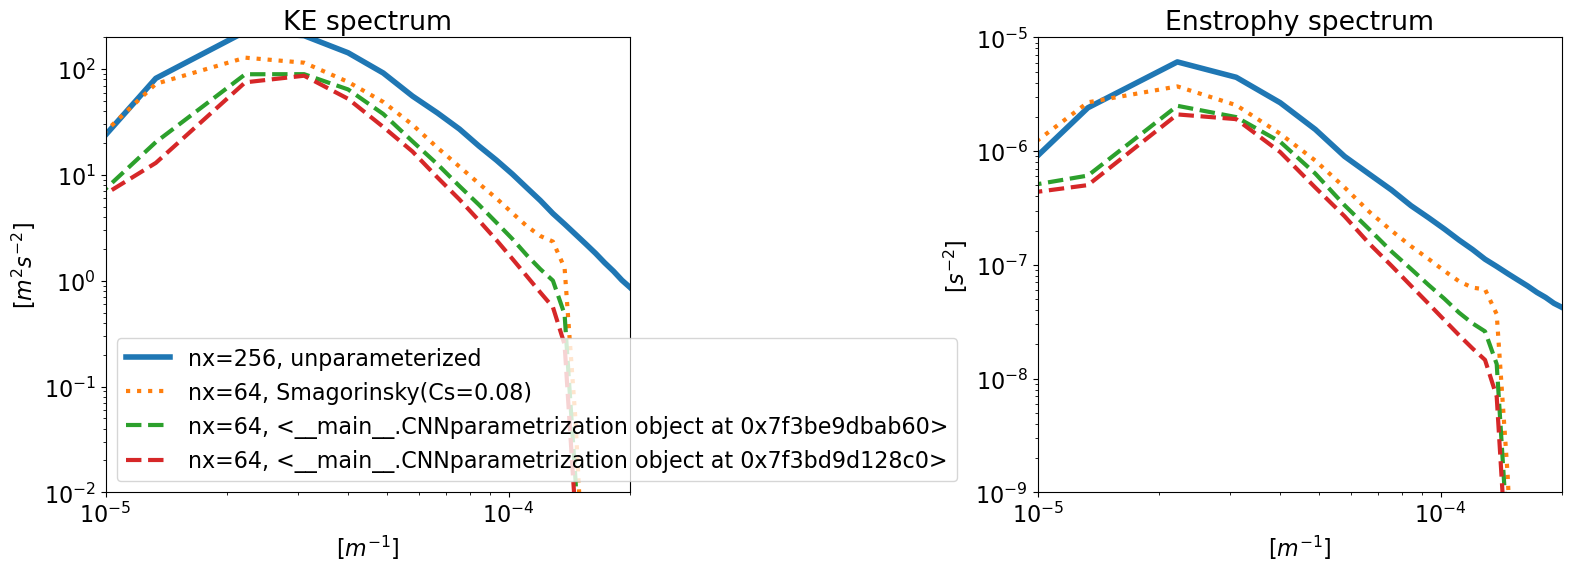

In [ ]:
def plot_kwargs_for(sim):
    kw = dict(label=label_for(sim).replace('Biharmonic',''))
    kw['ls'] = (':' if sim.uv_parameterization else ('--' if sim.q_parameterization else '-'))
    kw['lw'] = (4 if sim.nx==256 else 3)
    return kw

plt.figure(figsize=(16,6))
plt.rcParams.update({'font.size': 16})

plt.subplot(121, title="KE spectrum")
for sim in sims:
    plt.loglog(
        *pyqg.diagnostic_tools.calc_ispec(sim, sim.get_diagnostic('KEspec').sum(0)),
        **plot_kwargs_for(sim))
plt.ylabel("[$m^2 s^{-2}$]")
plt.xlabel("[$m^{-1}$]")
plt.ylim(1e-2,2e2)
plt.xlim(1e-5, 2e-4)
plt.legend(loc='lower left')

plt.subplot(122, title="Enstrophy spectrum")
for sim in sims:
    plt.loglog(
        *pyqg.diagnostic_tools.calc_ispec(sim, sim.get_diagnostic('Ensspec').sum(0)),
        **plot_kwargs_for(sim))
plt.ylabel("[$s^{-2}$]")
plt.xlabel("[$m^{-1}$]")
plt.ylim(1e-9,1e-5)
plt.xlim(1e-5, 2e-4)
plt.tight_layout()

In [ ]:
def plot_spectra(m):
    m_ds = m.to_dataset().isel(time=-1)
    diag_names_enstrophy = ['ENSflux', 'ENSgenspec', 'ENSfrictionspec', 'ENSDissspec', 'ENSparamspec']
    diag_names_energy = ['APEflux', 'APEgenspec', 'KEflux', 'KEfrictionspec', 'Dissspec', 'paramspec']

    bud_labels_list = [['APE gen','APE flux','KE flux','Bottom drag','Diss.','Param.'],
                       ['ENS gen','ENS flux','Dissipation','Friction','Param.']]
    title_list = ['Spectral Energy Transfer', 'Spectral Enstrophy Transfer']
    plt.figure(figsize = [15, 5])
    for p, diag_names in enumerate([diag_names_energy, diag_names_enstrophy]):
        bud = []
        for name in diag_names:
            kr, spec = pyqg.diagnostic_tools.calc_ispec(m, getattr(m_ds, name).data.squeeze())
            bud.append(spec.copy())
        plt.subplot(1, 2, p+1)
        [plt.semilogx(kr, term, label=label) for term, label in zip(bud, bud_labels_list[p])]
        plt.semilogx(kr, -np.vstack(bud).sum(axis=0), 'k--', label = 'Resid.')
        plt.legend(loc='best')
        plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
        plt.title(title_list[p])
    plt.tight_layout()

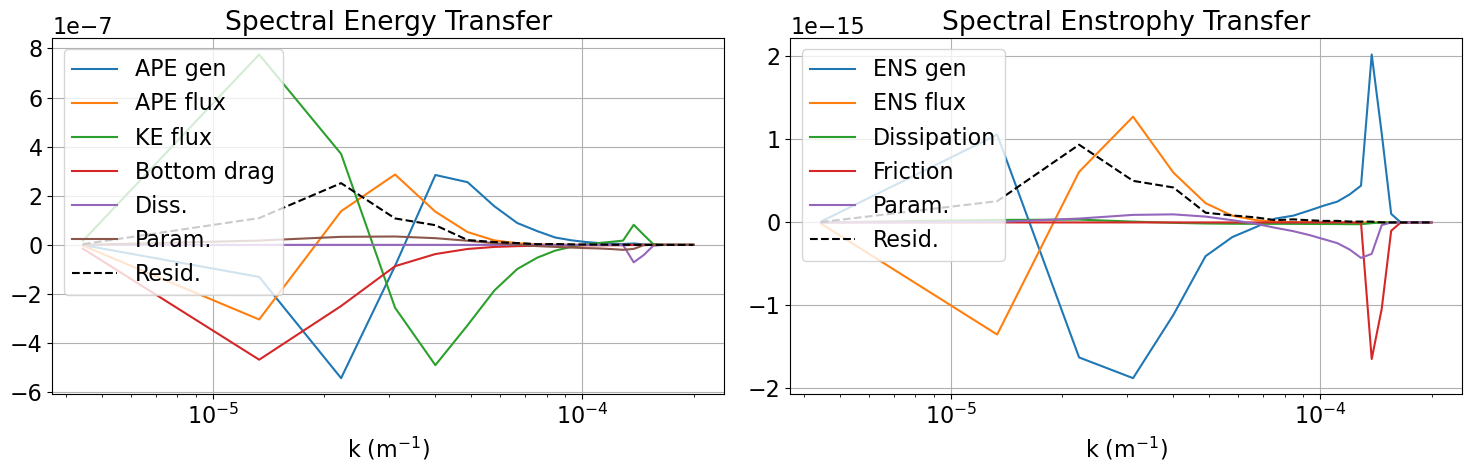

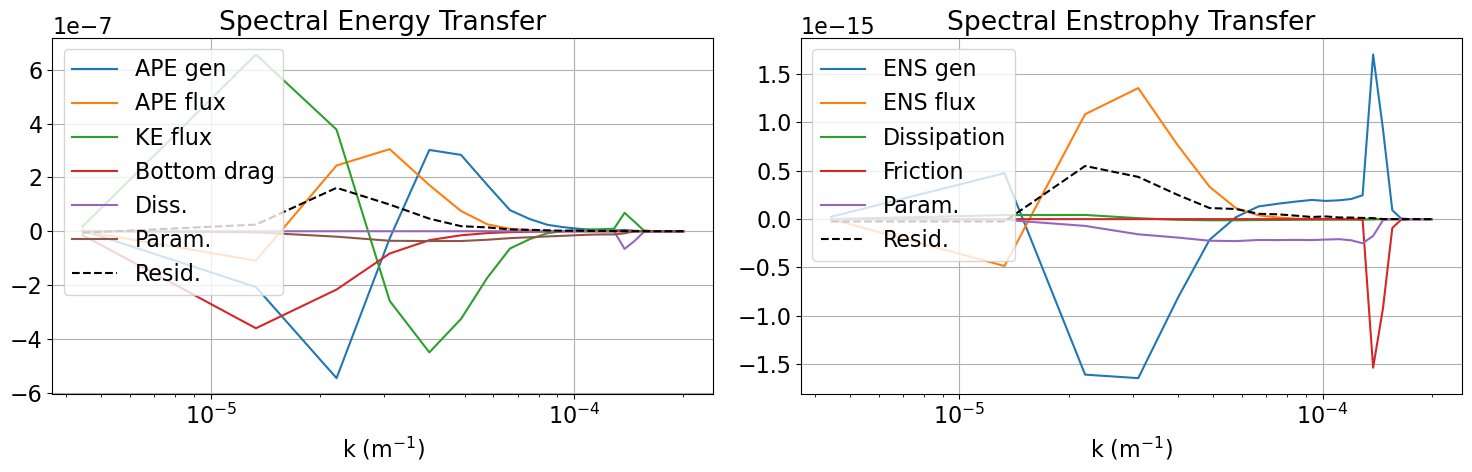

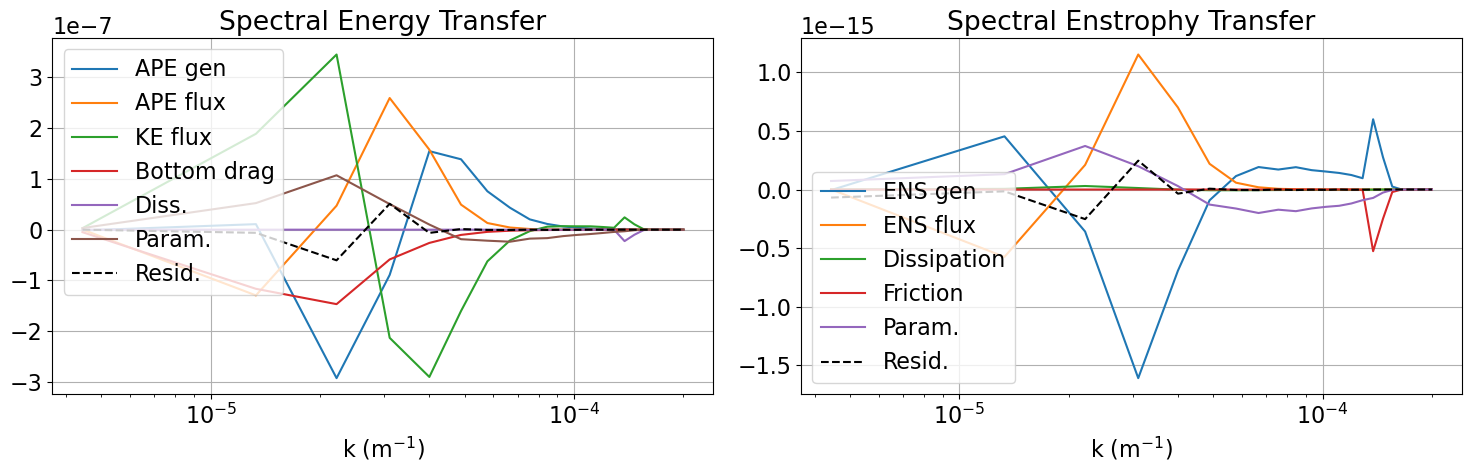

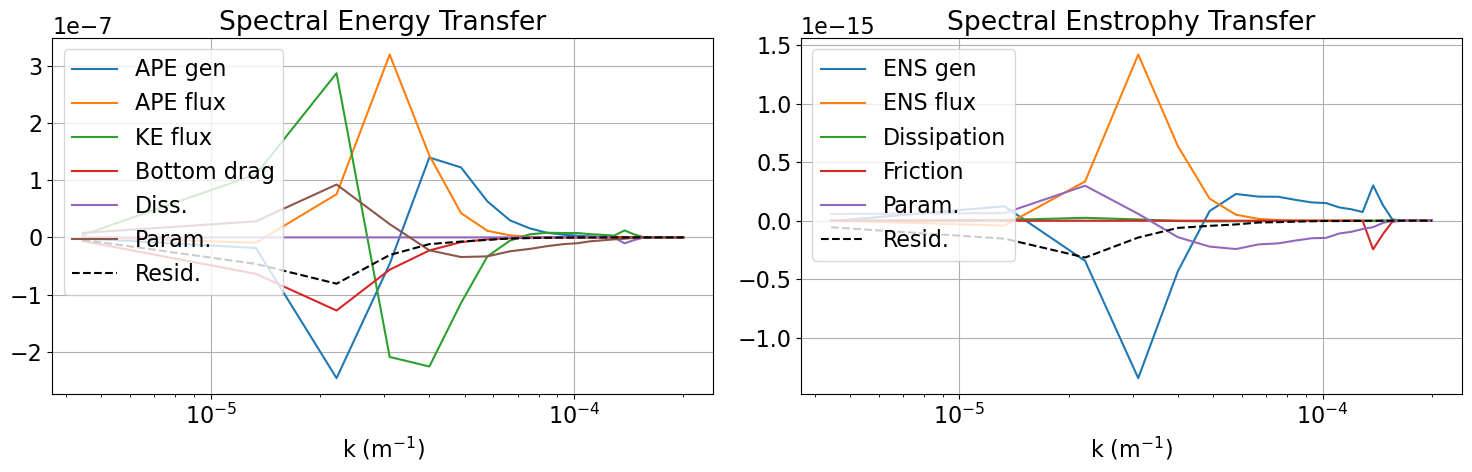

In [ ]:
plot_spectra(backscatter_case2)
plot_spectra(smagorinsky_case2)
plot_spectra(cnn_case2)
plot_spectra(TLNN_case2)



Case 2 (High-res)


ValueError: Dimensions {'time'} do not exist. Expected one or more of ('lev', 'y', 'x')

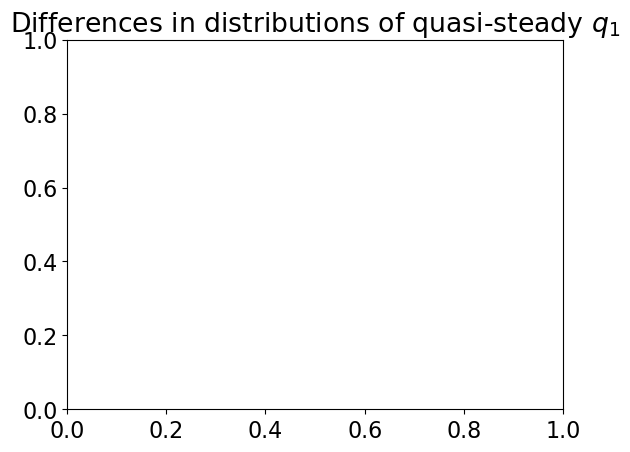

In [ ]:
from scipy.stats import gaussian_kde
plt.title("Differences in distributions of quasi-steady $q_1$")
eddy_sims = [(case2_highres_ds, "Case 2 (High-res)"), (case2_lowres_ds, "Case 2 (Low-res)"), (cnn_parametrization_ds, "Case 2 (CNN)"), (backscatter_case2_ds, "Case 2 (Backscatter)"), (smagorinsky_case2_ds, "Case 2 (Smagorinsky)")]
for i, (m, label) in enumerate(eddy_sims):
    print(label)
    data = m.q.isel(lev=0,time=slice(-20,None)).data.ravel()
    dist = gaussian_kde(data)
    x = np.linspace(*np.percentile(data, [1,99]), 1000)
    plt.plot(x, dist(x), label=label, lw=3, ls=('--' if 'FCNN' in label else '-'))
plt.legend()
plt.xlabel("Upper PV [$s^{-1}$]")
plt.ylabel("Probability density")
plt.tight_layout()

In [ ]:
for i, (m, label) in enumerate(eddy_sims):
    print(f"Dimensions for {label}:", m.dims)

Dimensions for Case 2 (High-res): Frozen({'lev': 2, 'y': 256, 'x': 256, 'l': 256, 'k': 129, 'lev_mid': 1})
Dimensions for Case 2 (Low-res): Frozen({'lev': 2, 'y': 64, 'x': 64, 'l': 64, 'k': 33, 'lev_mid': 1})
Dimensions for Case 2 (CNN): Frozen({'lev': 2, 'y': 64, 'x': 64, 'l': 64, 'k': 33, 'lev_mid': 1})
Dimensions for Case 2 (Backscatter): Frozen({'lev': 2, 'y': 64, 'x': 64, 'l': 64, 'k': 33, 'lev_mid': 1})
Dimensions for Case 2 (Smagorinsky): Frozen({'lev': 2, 'y': 64, 'x': 64, 'l': 64, 'k': 33, 'lev_mid': 1})


In [7]:
from pyqg_parameterization_benchmarks.neural_networks import FCNNParameterization


param = FCNNParameterization('/media/volume/sdc/qg/TransferLearning-QG/pyqg_parameterization_benchmarks/models/fcnn_q_to_Sqtot1')

param.models[0]

FullyCNN(
  (0): Conv2d(2, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=circular)
  (1): ReLU()
  (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=circular)
  (4): ReLU()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (7): ReLU()
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (10): ReLU()
  (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (13): ReLU()
  (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [12]:
eddy_forcing1

<xarray.Dataset>
Dimensions:            (run: 275, l: 64, k: 33, lev: 2, time: 87, y: 64, x: 64,
                        lev_mid: 1)
Coordinates:
  * k                  (k) float32 0.0 6.283e-06 ... 0.0001948 0.0002011
  * l                  (l) float32 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * lev                (lev) int32 1 2
  * lev_mid            (lev_mid) float32 1.5
  * time               (time) float32 0.0 3.6e+06 7.2e+06 ... 3.06e+08 3.096e+08
  * x                  (x) float32 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y                  (y) float32 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
Dimensions without coordinates: run
Data variables: (12/36)
    APEflux            (run, l, k) float32 dask.array<chunksize=(1, 64, 33), meta=np.ndarray>
    APEgen             (run) float32 dask.array<chunksize=(275,), meta=np.ndarray>
    APEgenspec         (run, l, k) float32 dask.array<chunksize=(1, 64, 33), meta=np.ndarray>
    Dissspec           (run, l, k) float32 dask.array<chunksize=(1, 64, 33), meta=np.ndarray>
    EKE                (run, lev) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    EKEdiss            (run) float32 dask.array<chunksize=(275,), meta=np.ndarray>
    ...                 ...
    uv_subgrid_flux    (run, time, lev, y, x) float32 dask.array<chunksize=(1, 87, 2, 64, 64), meta=np.ndarray>
    v                  (run, time, lev, y, x) float32 dask.array<chunksize=(1, 87, 2, 64, 64), meta=np.ndarray>
    v_subgrid_forcing  (run, time, lev, y, x) float32 dask.array<chunksize=(1, 87, 2, 64, 64), meta=np.ndarray>
    vfull              (run, time, lev, y, x) float32 dask.array<chunksize=(1, 87, 2, 64, 64), meta=np.ndarray>
    vq_subgrid_flux    (run, time, lev, y, x) float32 dask.array<chunksize=(1, 87, 2, 64, 64), meta=np.ndarray>
    vv_subgrid_flux    (run, time, lev, y, x) float32 dask.array<chunksize=(1, 87, 2, 64, 64), meta=np.ndarray>
Attributes: (12/26)
    hires:           256
    lores:           64
    pyqg:L:          1000000.0
    pyqg:M:          4096
    pyqg:W:          1000000.0
    pyqg:beta:       1.5e-11
    ...              ...
    pyqg:tc:         0
    pyqg:tmax:       311040000.0
    pyqg:twrite:     1000.0
    pyqg_params:     {"nx": 64, "dt": 3600.0, "tmax": 311040000.0, "tavestart...
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           Subgrid forcing dataset generated by coarsening nx=256 p...

In [23]:
import xarray as xr
eddy_forcing1 = xr.open_zarr('/media/volume/sdc/ross_data/publication/eddy/forcing1.zarr').isel(run=0).load()
eddy_forcing1['q_forcing_total'] = eddy_forcing1.dqdt_bar - eddy_forcing1.dqbar_dt


preds = param.test_offline(eddy_forcing1)

In [24]:
preds

<xarray.Dataset>
Dimensions:                               (time: 87, lev: 2, y: 64, x: 64)
Coordinates:
  * lev                                   (lev) int32 1 2
  * time                                  (time) float32 0.0 ... 3.096e+08
  * x                                     (x) float32 7.812e+03 ... 9.922e+05
  * y                                     (y) float32 7.812e+03 ... 9.922e+05
Data variables: (12/14)
    q_forcing_total                       (time, lev, y, x) float32 -2.647e-1...
    q_forcing_total_predictions           (time, lev, y, x) float32 3.847e-13...
    q_forcing_total_spatial_mse           (lev, y, x) float32 6.283e-24 ... 6...
    q_forcing_total_temporal_mse          (time, lev) float32 6.163e-28 ... 6...
    q_forcing_total_mse                   (lev) float32 5.378e-24 5.255e-28
    q_forcing_total_spatial_skill         (lev, y, x) float32 0.7949 ... 0.9415
    ...                                    ...
    q_forcing_total_spatial_correlation   (lev, y, x) float64 0.8881 ... 0.9754
    q_forcing_total_temporal_correlation  (time, lev) float64 0.01353 ... 0.9778
    q_forcing_total_correlation           (lev) float64 0.9387 0.9765
    correlation                           (lev) float64 0.9387 0.9765
    mse                                   (lev) float32 5.378e-24 5.255e-28
    skill                                 (lev) float32 0.8809 0.9533
Attributes: (12/26)
    hires:           256
    lores:           64
    pyqg:L:          1000000.0
    pyqg:M:          4096
    pyqg:W:          1000000.0
    pyqg:beta:       1.5e-11
    ...              ...
    pyqg:tc:         0
    pyqg:tmax:       311040000.0
    pyqg:twrite:     1000.0
    pyqg_params:     {"nx": 64, "dt": 3600.0, "tmax": 311040000.0, "tavestart...
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           Subgrid forcing dataset generated by coarsening nx=256 p...